In [ ]:
%matplotlib inline


# Comparison of kernel ridge regression and SVR


Both kernel ridge regression (KRR) and SVR learn a non-linear function by
employing the kernel trick, i.e., they learn a linear function in the space
induced by the respective kernel which corresponds to a non-linear function in
the original space. They differ in the loss functions (ridge versus
epsilon-insensitive loss). In contrast to SVR, fitting a KRR can be done in
closed-form and is typically faster for medium-sized datasets. On the other
hand, the learned model is non-sparse and thus slower than SVR at
prediction-time.

This example illustrates both methods on an artificial dataset, which
consists of a sinusoidal target function and strong noise added to every fifth
datapoint. The first figure compares the learned model of KRR and SVR when both
complexity/regularization and bandwidth of the RBF kernel are optimized using
grid-search. The learned functions are very similar; however, fitting KRR is
approx. seven times faster than fitting SVR (both with grid-search). However,
prediction of 100000 target values is more than tree times faster with SVR
since it has learned a sparse model using only approx. 1/3 of the 100 training
datapoints as support vectors.

The next figure compares the time for fitting and prediction of KRR and SVR for
different sizes of the training set. Fitting KRR is faster than SVR for medium-
sized training sets (less than 1000 samples); however, for larger training sets
SVR scales better. With regard to prediction time, SVR is faster than
KRR for all sizes of the training set because of the learned sparse
solution. Note that the degree of sparsity and thus the prediction time depends
on the parameters epsilon and C of the SVR.



SVR complexity and bandwidth selected and model fitted in 0.542 s
{'C': 0.8, 'gamma': 1.0}   0.6850969635593596
{'mean_fit_time': array([0.00087051, 0.00076876, 0.00050216, 0.00052757, 0.0004756 ,
       0.00040636, 0.00035567, 0.00036206, 0.00049138, 0.00046954,
       0.00032868, 0.0003572 , 0.00033898, 0.0005476 , 0.00056119,
       0.00072188, 0.00086522, 0.00071306, 0.00069008, 0.00077   ,
       0.00262175, 0.00276546, 0.0018209 , 0.00351882, 0.00174513,
       0.013026  , 0.00820589, 0.00739756, 0.02272348, 0.00949826]), 'std_fit_time': array([1.70746018e-04, 2.10729474e-04, 2.07535034e-04, 6.23898009e-05,
       4.14737051e-05, 1.63225308e-04, 6.53815561e-05, 6.12216202e-05,
       8.68545500e-05, 2.53166854e-05, 1.19291277e-05, 4.14347620e-05,
       2.77936759e-05, 1.92984393e-04, 1.58145141e-04, 1.27479844e-04,
       1.71992393e-04, 9.93902288e-05, 7.39828794e-05, 1.25807644e-04,
       7.25318545e-04, 1.08929501e-03, 4.66636765e-04, 1.73453392e-03,
       4.96397573e-04, 6

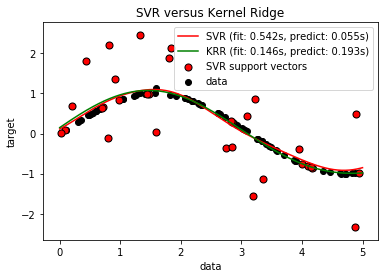

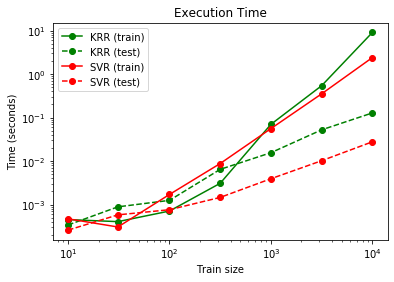

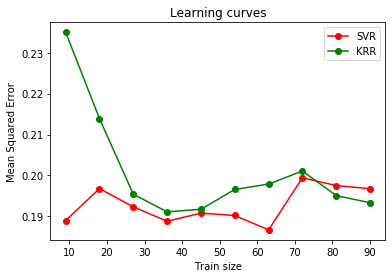

In [28]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause


import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

# #############################################################################
# Fit regression model
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1.0, 5,10.0, 100.0, 1000.0],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)
print(svr.best_params_)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)
print(kr.best_params_)
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))


# #############################################################################
# Look at the results
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()

# Visualize training and prediction time
plt.figure()

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
sizes = np.logspace(1, 4, 7).astype(np.int)
for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

In [34]:
#{'C': 1.0, 'gamma': 1.0}   0.6805261961598004
#{'C': 0.7, 'gamma': 0.7}   0.6866879319467653
#{'C': 0.6, 'gamma': 0.7}   0.6878801692750733
#{'C': 0.6, 'gamma': 0.6}   0.6879089309270618
np.logspace(-2, 2, 100)

array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.05385551e-02, 3.35160265e-02, 3.67837977e-02, 4.03701726e-02,
       4.43062146e-02, 4.86260158e-02, 5.33669923e-02, 5.85702082e-02,
       6.42807312e-02, 7.05480231e-02, 7.74263683e-02, 8.49753436e-02,
       9.32603347e-02, 1.02353102e-01, 1.12332403e-01, 1.23284674e-01,
       1.35304777e-01, 1.48496826e-01, 1.62975083e-01, 1.78864953e-01,
       1.96304065e-01, 2.15443469e-01, 2.36448941e-01, 2.59502421e-01,
       2.84803587e-01, 3.12571585e-01, 3.43046929e-01, 3.76493581e-01,
       4.13201240e-01, 4.53487851e-01, 4.97702356e-01, 5.46227722e-01,
       5.99484250e-01, 6.57933225e-01, 7.22080902e-01, 7.92482898e-01,
       8.69749003e-01, 9.54548457e-01, 1.04761575e+00, 1.14975700e+00,
       1.26185688e+00, 1.38488637e+00, 1.51991108e+00, 1.66810054e+00,
      

SVR complexity and bandwidth selected and model fitted in 0.510 s
{'C': 1.0, 'gamma': 1.0}   0.6805261961598004
KRR complexity and bandwidth selected and model fitted in 0.156 s
{'alpha': 0.1, 'gamma': 0.1}   0.6646296050815007
Support vector ratio: 0.310
SVR prediction for 100000 inputs in 0.055 s
KRR prediction for 100000 inputs in 0.172 s


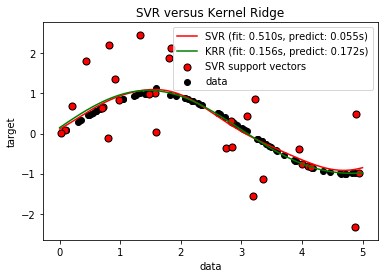

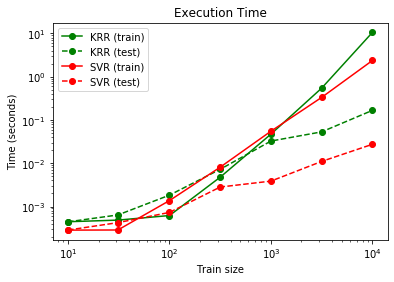

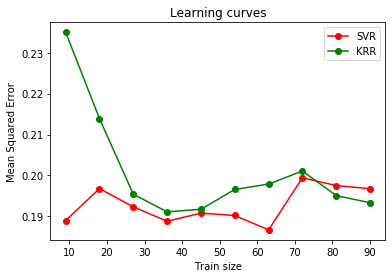

In [21]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause


import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

# #############################################################################
# Fit regression model
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [0.1,1.0, 10.0, 100.0, 1000.0],
                               "gamma": [0.01, 0.1, 1.0, 1.5,10.0, 100.0]}) #np.logspace(-2, 2, 5)

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)
print(svr.best_params_," ", svr.best_score_)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)
print(kr.best_params_," ", kr.best_score_)
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))


# #############################################################################
# Look at the results
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()

# Visualize training and prediction time
plt.figure()

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
sizes = np.logspace(1, 4, 7).astype(np.int)
for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

In [ ]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause


import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

# #############################################################################
# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

# #############################################################################
# Fit regression model
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [0.8,0.9, 1.0,10.0, 100.0, 1000.0],
                               "gamma": [0.8, 1.0, 1.3,10.0, 100.0]}) #np.logspace(-2, 2, 5)

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)
print(svr.best_params_," ", svr.best_score_)
print (svr.cv_results_)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)
print(kr.best_params_," ", kr.best_score_)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))


# #############################################################################
# Look at the results
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1,
            edgecolors=(0, 0, 0))
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()

# Visualize training and prediction time
plt.figure()

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))
sizes = np.logspace(1, 4, 7).astype(np.int)
for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()